# Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro, ttest_ind

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# Датасет

In [2]:
PATH = "/content/drive/MyDrive/Colab Notebooks/ПМ-2022/АД/data/mushroom.csv"
df = pd.read_csv(PATH, sep = ",")
df.head()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,1856.0,6.0,4.0,10,3.711971,3569.0,11,0.943195,0
1,1858.0,6.0,4.0,5,3.592601,3569.0,11,0.943195,0
2,1663.0,6.0,4.0,11,2.235766,3568.0,12,0.888450,1
3,1294.0,2.0,4.0,11,0.461988,3568.0,6,0.943195,1
4,1262.0,6.0,0.0,10,2.621728,3567.0,11,0.943195,1


In [3]:
df.shape

(54035, 9)

# Описательный анализ

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54035 entries, 0 to 54034
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cap-diameter     54032 non-null  float64
 1   cap-shape        54033 non-null  float64
 2   gill-attachment  54034 non-null  float64
 3   gill-color       54035 non-null  int64  
 4   stem-height      54035 non-null  float64
 5   stem-width       54033 non-null  float64
 6   stem-color       54035 non-null  int64  
 7   season           54035 non-null  float64
 8   class            54035 non-null  int64  
dtypes: float64(6), int64(3)
memory usage: 3.7 MB


Наблюдаются пропуски, на которые мы взглянем отдельно.

Все признаки числовые, однако, они могут быть как номинальными, так и порядковыми, то есть закодированными категориальными. Для этого посмотрим на кол-во уникальных значений в каждом признаке.

In [5]:
for col in df:
    print(f'{col}: {df[col].nunique()}')

cap-diameter: 1847
cap-shape: 7
gill-attachment: 7
gill-color: 12
stem-height: 1455
stem-width: 3510
stem-color: 13
season: 4
class: 2


Итак, к номинальным числовым признакам относятся диаметр шляпки, высота и ширина ножки, целевой признак class является бинарным, остальные признаки категориальные, которые не должны быть порядковыми (гладкая форма шляпки не сравнима с шершавой и тд) и которые нужно будет перекодировать OneHotEncoder-ом в бинарные.

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cap-diameter,54032.0,567.287700,359.870481,0.000000,289.000000,525.000000,781.000000,1891.000000
cap-shape,54033.0,4.000241,2.160511,0.000000,2.000000,5.000000,6.000000,6.000000
gill-attachment,54034.0,2.142077,2.228836,0.000000,0.000000,1.000000,4.000000,6.000000
gill-color,54035.0,7.329509,3.200266,0.000000,5.000000,8.000000,10.000000,11.000000
stem-height,54035.0,0.759110,0.650969,0.000426,0.270997,0.593295,1.054858,3.835320
stem-width,54033.0,1051.117743,782.047608,0.000000,421.000000,923.000000,1523.000000,3569.000000
stem-color,54035.0,8.418062,3.262078,0.000000,6.000000,11.000000,11.000000,12.000000
season,54035.0,0.952163,0.305594,0.027372,0.888450,0.943195,0.943195,1.804273
class,54035.0,0.549181,0.497580,0.000000,0.000000,1.000000,1.000000,1.000000


1.   Диаметр шляпки: есть пропуски, в среднем размер 567, размах 359, смущает минимальное значение 0. что скорее всего свидетельствует о скрытом пропуске в данных, медиана близка к среднему, перцентили равномерно распределены, значит, данные скорее всего нормально распределены (проверить гипотезу), нужно масштабировать: непонятные единицы измерения
2.   Форма шляпки: есть пропуски, 7 категорий
3.   Способ крепления пластин: есть пропуск, 7 категорий
4.   Цвет пластин: пропусков нет, 12 категорий
5.   Высота ножки: пропусков нет, числовой, среднее значение 0.75, размах 0.65, по перцентилям распределение нормальное, но по разнице в медиане и среднем делаем вывод о перекосе пика в меньшую сторону, данные явно отмасштабированы
6.   Ширина ножки: есть пропуски, числовой, среднее значение 1051, размах 782, судя по минимуму, есть скрытые пропуски в данных, нормальное распределение, нужно масштабировать: непонятные единицы измерения
7.   Цвет ножки: пропусков нет, 13 категорий
8.   Сезон: пропусков нет, 4 категории, при этом отмасштабированные (проанализировать где какой сезон)
9.   Целевой признак class: бинарный, сбалансирован. есть небольшой перекос в сторону класса 1 (ядовитых): 55%:45%



In [7]:
df.shape

(54035, 9)

Подытожим, что в датасете 54035 объекта, 9 признаков, из которых 1 целевой.

In [8]:
df["class"].value_counts(normalize=True)

,proportion
class,
1,0.549181
0,0.450819


Другой способ отображения баланса классов

In [9]:
df.columns = df.columns.str.replace("-", "_")

Заменили в названиях признаков - на _

In [10]:
df.columns = df.columns.str.replace("class", "target")

По тем же причинам заменили зарезервированное имя class на target

In [11]:
for col in df:
    print(f'{col}: {df[col].nunique()}')

cap_diameter: 1847
cap_shape: 7
gill_attachment: 7
gill_color: 12
stem_height: 1455
stem_width: 3510
stem_color: 13
season: 4
target: 2


In [12]:
categorical_columns = ["cap_shape", "gill_attachment", "gill_color", "stem_color", "season"]
for col in categorical_columns:
    print(df[col].value_counts(normalize=True))

cap_shape
6.0    0.432606
2.0    0.227528
5.0    0.127496
0.0    0.097589
3.0    0.051450
1.0    0.031869
4.0    0.031462
Name: proportion, dtype: float64
gill_attachment
0.0    0.359126
1.0    0.185531
6.0    0.129567
5.0    0.097938
4.0    0.088740
2.0    0.082800
3.0    0.056298
Name: proportion, dtype: float64
gill_color
10    0.305931
11    0.152013
5     0.150902
7     0.100953
3     0.071195
2     0.056297
6     0.050227
4     0.032794
8     0.023522
1     0.019598
9     0.018932
0     0.017637
Name: proportion, dtype: float64
stem_color
11    0.375997
6     0.283446
12    0.129860
3     0.048598
1     0.035496
7     0.034200
10    0.025780
2     0.019598
8     0.018969
4     0.010660
9     0.010012
5     0.004182
0     0.003202
Name: proportion, dtype: float64
season
0.943195    0.503563
0.888450    0.377292
1.804273    0.078079
0.027372    0.041066
Name: proportion, dtype: float64


Можно написать выводы о популярных значениях категориальных признаков, но лучше сделать это на графиках ниже.
Популярные:
1.   форма шляпки: 6, 2, 5
2.   способ крепления пластин: 0, 1, 6
3.   цвет пластин: 10, 11, 5, 7
4.   цвет ножки: 11, 6, 12
5.   сезон: 0.943195, 0.888450



# Очистка данных

In [13]:
df.isnull().sum()

,0
cap_diameter,3
cap_shape,2
gill_attachment,1
gill_color,0
stem_height,0
stem_width,2
stem_color,0
season,0
target,0


В общем объеме 54035 объектов в датасете пропуски 1-3 объекта незначительны, их в большинстве случаев удалили бы, НО они стоят денег, их можно спасти.

In [14]:
df[df["cap_diameter"].isnull()]

,cap_diameter,cap_shape,gill_attachment,gill_color,stem_height,stem_width,stem_color,season,target
52103,NaN,2.0,1.0,6,0.764392,47.0,12,0.88845,1
52109,NaN,2.0,1.0,6,0.549526,47.0,7,0.88845,1
52143,NaN,2.0,1.0,6,0.605232,46.0,12,0.88845,1


Можно заменить пропуски на медиану данного столбца, однако, мы попробуем найти максимально похожие на него объекты

In [15]:
tmp = df[(df["cap_shape"]==2.0) & (df["gill_attachment"]==1.0) & (df["gill_color"]==6) & (abs(df["season"]-0.888450)<0.001) & (df["target"]==1) & (df["stem_height"]>0.5) & (df["stem_width"]>=45) & (df["stem_width"]<=48)].drop_duplicates()
med = tmp["cap_diameter"].median()
med, df["cap_diameter"].median()

(22.0, 525.0)

После отбора объектов, максимально похожих на наш, медиана у них по признаку cap_diameter кардинально отличается от медианы по всему датасету для данного признака. Заменяем теперь пропуски на найденную медиану

In [16]:
df["cap_diameter"].fillna(med, inplace=True)

<ipython-input-16-ba5719dc7535>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["cap_diameter"].fillna(med, inplace=True)


In [17]:
df[df["cap_shape"].isnull()]

,cap_diameter,cap_shape,gill_attachment,gill_color,stem_height,stem_width,stem_color,season,target
52922,6.0,NaN,0.0,11,1.106585,14.0,12,0.943195,1
52935,7.0,NaN,0.0,11,1.098627,12.0,12,0.943195,1


In [18]:
df[(df["gill_attachment"]==0) & (df["gill_color"]==11) & (df["stem_height"]>=1.09) & (df["stem_height"]<=1.11) & (df["stem_color"]==12) & (abs(df["season"]-0.94)<0.1) & (df["target"]==1)]

,cap_diameter,cap_shape,gill_attachment,gill_color,stem_height,stem_width,stem_color,season,target
36442,201.0,6.0,0.0,11,1.102606,561.0,12,0.943195,1
36551,172.0,6.0,0.0,11,1.090669,558.0,12,0.943195,1
43920,158.0,2.0,0.0,11,1.097775,276.0,12,0.888450,1
52648,31.0,6.0,0.0,11,1.090669,30.0,12,0.888450,1
52759,28.0,6.0,0.0,11,1.102606,24.0,12,0.888450,1
52782,38.0,6.0,0.0,11,1.098627,23.0,12,0.888450,1
52786,16.0,6.0,0.0,11,1.102606,22.0,12,0.943195,1
52827,17.0,6.0,0.0,11,1.098627,20.0,12,0.943195,1
52855,19.0,6.0,0.0,11,1.106585,18.0,12,0.888450,1
52870,37.0,6.0,0.0,11,1.106585,18.0,12,0.943195,1


In [19]:
df["cap_shape"].fillna(6, inplace=True)

<ipython-input-19-9ef555ec7cb6>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["cap_shape"].fillna(6, inplace=True)


In [20]:
df[df["gill_attachment"].isnull()]

,cap_diameter,cap_shape,gill_attachment,gill_color,stem_height,stem_width,stem_color,season,target
52264,7.0,6.0,NaN,6,0.796223,44.0,12,0.88845,1


In [21]:
df[(abs(df["cap_diameter"]-7)<10) & (df["cap_shape"]==6) & (df["gill_color"]==6) & (abs(df["stem_width"]-44)<10) & (df['stem_color']==12) & (abs(df["season"]-0.88845)<0.01) & (df["target"]==1)]

,cap_diameter,cap_shape,gill_attachment,gill_color,stem_height,stem_width,stem_color,season,target
52264,7.0,6.0,NaN,6,0.796223,44.0,12,0.88845,1
52430,11.0,6.0,1.0,6,0.613190,40.0,12,0.88845,1
52456,16.0,6.0,1.0,6,0.800202,39.0,12,0.88845,1
52491,13.0,6.0,1.0,6,0.887740,38.0,12,0.88845,1


In [22]:
df["gill_attachment"].fillna(1, inplace=True)

<ipython-input-22-819ed51f87ab>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["gill_attachment"].fillna(1, inplace=True)


In [23]:
df[df["stem_width"].isnull()]

,cap_diameter,cap_shape,gill_attachment,gill_color,stem_height,stem_width,stem_color,season,target
51496,14.0,4.0,0.0,3,1.472652,NaN,11,1.804273,0
51534,15.0,2.0,1.0,6,0.366493,NaN,7,0.943195,1


Поднадоело. В данном случае надо искать отдельно похожие объекты на первый и отдельно на второй, так как общего у них ничего нет. Но оно того не стоит, поэтому заменим на медиану по stem_width по всему датасету

In [24]:
df["stem_width"].fillna(df["stem_width"].median(), inplace=True)

<ipython-input-24-4fdc93b42cbf>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["stem_width"].fillna(df["stem_width"].median(), inplace=True)


In [25]:
df.isnull().sum()

,0
cap_diameter,0
cap_shape,0
gill_attachment,0
gill_color,0
stem_height,0
stem_width,0
stem_color,0
season,0
target,0


Все явные пропуски ликвидированы. А неявные посмотрим визуально.

<Axes: >

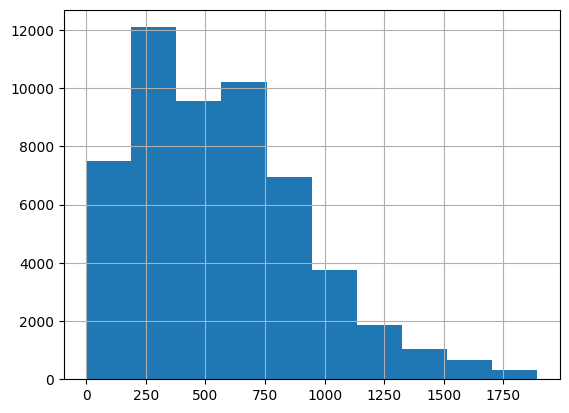

In [26]:
df["cap_diameter"].hist()

<Axes: >

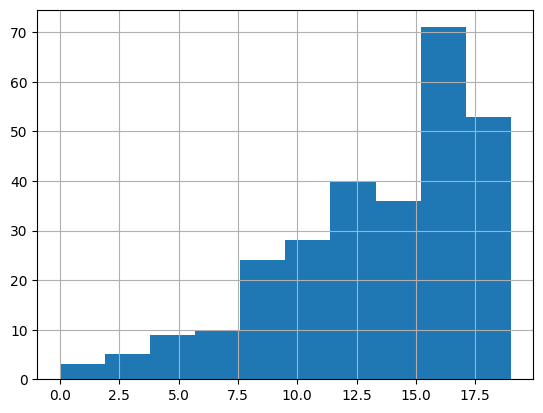

In [27]:
df[df["cap_diameter"]<20]["cap_diameter"].hist()

В случае нулевых значений в признаке cap_diameter считаем, что виновата шкала, а не неявные пропуски данных, так как с нуля кол-во значений равномерно растет, нет явно выраженного нулевого столбца, а шкала явно намекает на пеемасштабирование измерений.

<Axes: >

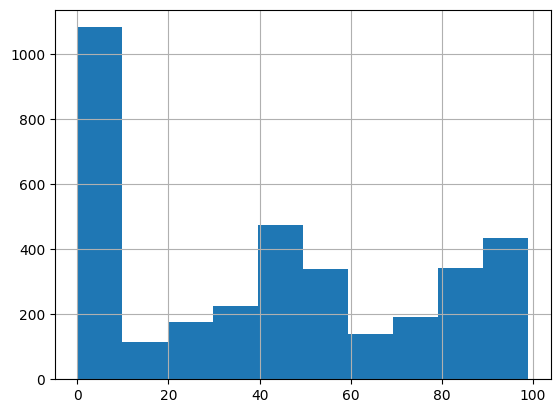

In [28]:
df[df["stem_width"]<100]["stem_width"].hist()

Наличие пикового значения у нулей в признаке stem_width несмотря на нестандартную шкалу намекает все же на наличие значительного числа пропусков. Надо их исправить. Заменим на медиану среди ненулевых.

In [29]:
med = df[df["stem_width"]>0]["stem_width"].median()
df["stem_width"].replace(0, med, inplace=True)

<ipython-input-29-2dc4c7c32c02>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["stem_width"].replace(0, med, inplace=True)


Заменили, неявные пропуски ликвидировали

# Визуализация

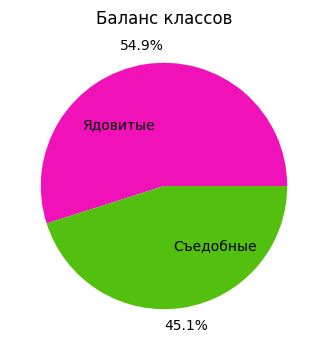

In [30]:
plt.figure(figsize=(4, 4))
plt.pie(df["target"].value_counts(), labels=["Ядовитые", "Съедобные"], labeldistance=0.5,
        autopct='%1.1f%%', pctdistance=1.15,
        colors=["#f011b8", "#53bf0f"])
plt.title(label="Баланс классов")
plt.show()

В датасете преобладают (на 10%) ядовитые грибы, как мы видели ранее в описательном анализе. Такую незначительную разницу в балансе игнорируем. Считаем, что целевой признак сбалансирован

In [31]:
df.corr(method='spearman')

,cap_diameter,cap_shape,gill_attachment,gill_color,stem_height,stem_width,stem_color,season,target
cap_diameter,1.000000,0.185546,0.305217,0.219728,0.041821,0.875168,0.070387,0.098406,-0.187262
cap_shape,0.185546,1.000000,0.071889,0.142247,0.034181,0.202937,0.038383,0.050108,-0.127997
gill_attachment,0.305217,0.071889,1.000000,0.114296,-0.075199,0.327965,0.023405,-0.012126,-0.061537
gill_color,0.219728,0.142247,0.114296,1.000000,-0.011244,0.148579,0.185980,0.037277,-0.057532
stem_height,0.041821,0.034181,-0.075199,-0.011244,1.000000,0.070997,-0.013012,0.000013,0.198088
stem_width,0.875168,0.202937,0.327965,0.148579,0.070997,1.000000,0.095019,0.077856,-0.204001
stem_color,0.070387,0.038383,0.023405,0.185980,-0.013012,0.095019,1.000000,0.019379,-0.104076
season,0.098406,0.050108,-0.012126,0.037277,0.000013,0.077856,0.019379,1.000000,-0.067507
target,-0.187262,-0.127997,-0.061537,-0.057532,0.198088,-0.204001,-0.104076,-0.067507,1.000000


<Axes: >

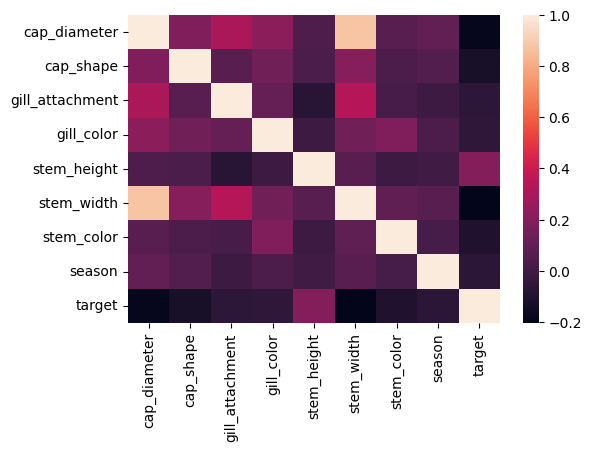

In [32]:
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(method='spearman'))

Вывели тепловую карту попарной корреляции столбцов. Выбрали для вычисления корреляции метод Спирмена как более подходящий для данных в числовом формате.

Из матрицы видно, что самая сильная корреляция целевого признака с stem_height (положительная), stem_width (отрицательная), cap_diameter (отрицательная).

Также видна сильная корреляция между толщиной ножки и диаметром шляпки, однако, избавляться ни от одного признака не будем, так как это не избыточность информации, а отражение физики мира.

In [33]:
gr = df.groupby(["target", "season"]).size()
eatable_by_seasons = gr[0]
poison_by_seasons =  gr[1]

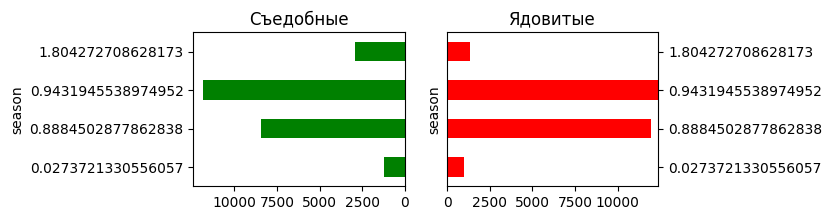

In [34]:
_, ax = plt.subplots(1, 2, figsize = (6, 2))
eatable_by_seasons.plot.barh(eatable_by_seasons, color="green", ax=ax[0])
ax[0].yaxis.tick_left()
ax[0].set_title("Съедобные")
ax[0].set_xlim(ax[0].get_xlim()[::-1])

poison_by_seasons.plot.barh(poison_by_seasons, color="red", ax=ax[1])
ax[1].yaxis.tick_right()
ax[1].set_title("Ядовитые")
ax[1].set_xlim(ax[0].get_xlim()[::-1])

plt.show()

Из графика делаем вывод:
1.   094... - осень (много грибов)
2.   0.888.. - лето (много, но поменьше)
3.   1.804.. - весна
4.   0.027.. - зима



In [35]:
set(df['season'])

{0.0273721330556057, 0.8884502877862838, 0.9431945538974952, 1.804272708628173}

In [36]:
sesson_map = {0.0273721330556057:'зима', 0.8884502877862838:"лето", 0.9431945538974952:"осень", 1.804272708628173:"весна"}
df['season_1'] = df['season'].map(sesson_map)

Переименовали классы сезонов согласно выводов выше

In [37]:
df['season_1'].value_counts(normalize=True)

,proportion
season_1,
осень,0.503563
лето,0.377292
весна,0.078079
зима,0.041066


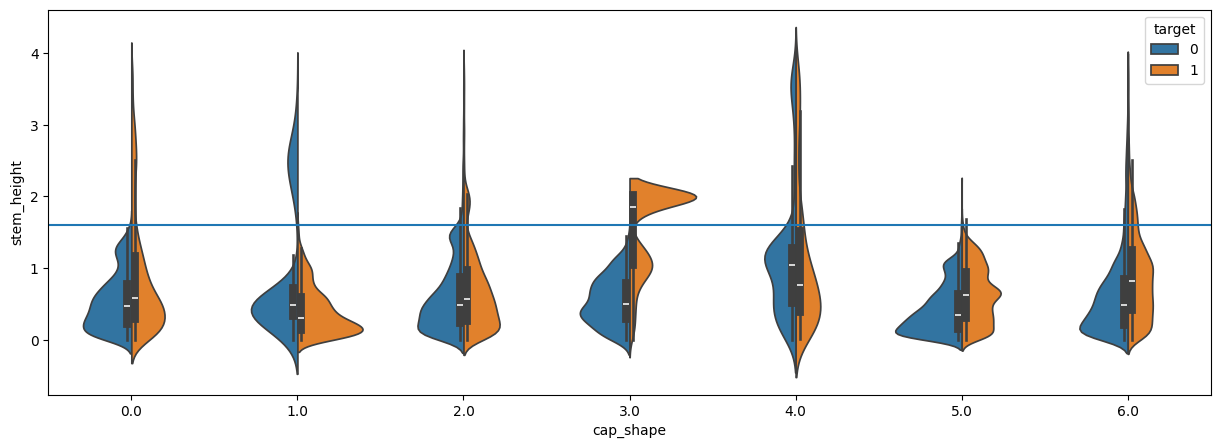

In [38]:
fig, ax = plt.subplots(figsize=(15,5))
sns.violinplot(x='cap_shape', y='stem_height', hue='target', data=df, split=True)
plt.axhline(y=1.6)

Высота ножки у большинства объектов датасета из (0, 1.6) усл.ед. Выводы:
*   Если форма шляпки 3 и высота ножки > 1.6 у.е., то высока вероятность, что гриб ядовит; если форма шляпки 3, то среднее значение у ядовитых и съедобных сильно различается
*   Если форма шляпки 0 и высота ножки > 1.6 у.е., то высока вероятность, что гриб ядовит
*   Если форма шляпки 4 и высота ножки от 1.6 у.е. до 3 у.е., то высока вероятность, что гриб ядовит
*   Если форма шляпки 1 и высота ножки > 1.6у.е., то высока вероятность, что гриб съедобен
*   Если форма шляпки 6 и высота ножки > 1.6у.е., то высока вероятность, что гриб ядовит



<ipython-input-39-bee1288441d4>:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['зима', 'лето','осень','весна'])


[Text(0, 0, 'зима'),
 Text(1, 0, 'лето'),
 Text(2, 0, 'осень'),
 Text(3, 0, 'весна')]

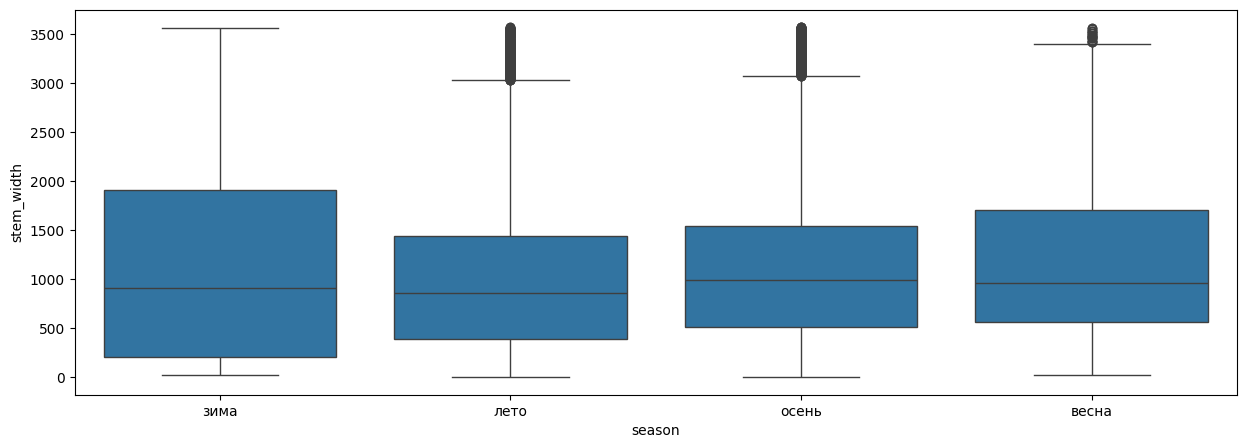

In [39]:
_, ax = plt.subplots(figsize=(15,5))
ax = sns.boxplot(data=df, x='season', y='stem_width')
ax.set_xticklabels(['зима', 'лето','осень','весна'])

среднее значение по всем сезонам примерно одинаковое и около 1000 у.е. Весной и зимой диапазон значений у толщины ножки шире, чем осенью и летом. Осенью и летом практически не встречаются грибы с шириной ножки больше 3000 у.е. Выбросов больше всего летом и осенью

<Axes: xlabel='cap_diameter', ylabel='stem_height'>

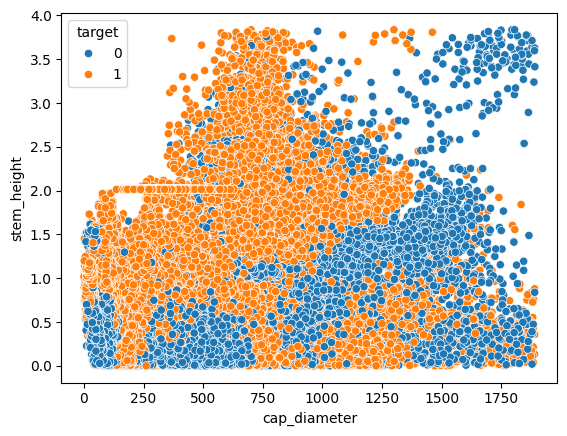

In [40]:
sns.scatterplot(x='cap_diameter', y='stem_height', hue='target', data=df)

Выводы:
*   если диаметр шляпки от 250 до 700 у.е., высота ножки от 0 до 0,75 у.е., то скорее всего гриб съедобен
*   если диаметр шляпки больше 1500 у.е., то гриб скорее всего съедобен



In [41]:
dfm = df.groupby(['target', 'stem_color']).size().to_frame().rename(columns={0: "Кол-во вхождений"})
dfm

Кол-во вхождений
target stem_color                  
0      0                        173
       1                        538
       3                       1594
       5                        105
       6                       5776
       7                        858
       8                        132
       9                        114
       10                       533
       11                     12043
       12                      2494
1      1                       1380
       2                       1059
       3                       1032
       4                        576
       5                        121
       6                       9540
       7                        990
       8                        893
       9                        427
       10                       860
       11                      8274
       12                      4523

Представим таблицу выше в виде Sankey-диаграммы.

In [42]:
# для лучшей интерпретации заменим значения принадлежности к классу на строковые переменные
def changing(numb):
    if numb == 1:
        return 'ядовитый'
    else:
        return 'съедобный'

In [43]:
df_t = df[['target', 'stem_color']]
df_t = df_t.copy()

In [44]:
df_t.loc[:, 'target'] = df_t['target'].apply(lambda x: changing(x))

<ipython-input-44-0d4dd8a3fb66>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['съедобный' 'съедобный' 'ядовитый' ... 'ядовитый' 'ядовитый' 'ядовитый']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_t.loc[:, 'target'] = df_t['target'].apply(lambda x: changing(x))


Некоторые значения отсутствовали (их сумма равнялась нулю). Это может вызвать проблемы, т. к. в матрице будут отсутствовать значения. По этой причине заполним датафрейм недостающими нулями.

In [45]:
dfg = df_t.groupby(['target', 'stem_color']).size().unstack(fill_value=0).stack()

In [46]:
# импорт библиотеки для отрисовки Sankey Diagram
import plotly.graph_objects as go

In [47]:
# матрица размерности 13x2
m = dfg.to_numpy().reshape(13, 2)
stem_color_lst = sorted(df['stem_color'].unique())
class_lst = sorted(df_t['target'].unique())

In [48]:
poisonous, edible = '#C79FEF', '#AAA662'

In [49]:
# функция отрисовки Sankey Diagram
def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf', "blue", "black", "green", edible, '#C1F80A']
    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('lightgray' if i in h1 or j in h2 else 'pink')

    fig = go.Figure(data=[go.Sankey(
        valueformat = ".0f",
        valuesuffix = "TWh",
        # Define nodes
        node = dict(
        pad = 29,
        thickness = 40,
        line = dict(color = "purple", width = 0.4),
        label =  all_nodes,
        color = colors
        ),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])

    fig.update_layout(title_text="Sankey-диаграмма взаимосвязи цвета стебля и съедобности грибов", font_size=12)
    fig.show(dpi=600)

    return fig

In [50]:
diagram = sankey(stem_color_lst, class_lst, m, 100, h2=[0])
diagram.write_html('sankey.html', auto_open=True)

Выводы: если цвет ножки 5 или 9, то скорее всего ядовитый гриб, а если цвет 12 или 3. то съедобный

# Гипотезы

**Гипотеза 1.**
Проверим гипотезу: распределение у признака cap_diameter нормально
*   H0 - нулевая гипотеза: распределение нормальное
*   H1 - альтернативная гипотеза: не является таковым

α = 0.05



In [51]:
shapiro(df["cap_diameter"])

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 54035.



ShapiroResult(statistic=0.9546031318691477, pvalue=1.2577427872894287e-79)

Вывод: p-value оказался ниже уровня статистической значимости, так что нулевая гипотеза отвергается и принимается альтернативная, что распределение не является нормальным.

**Гипотеза 2.** Проверим гипотезу: распределение у выборки cap_shape=3 по признаку stem_height нормально
*   H0 - нулевая гипотеза: распределение нормальное
*   H1 - альтернативная гипотеза: не является таковым

α = 0.05



In [52]:
shapiro(df[df["cap_shape"]==3]['stem_height'])

ShapiroResult(statistic=0.8380307699637459, pvalue=1.0632718387217383e-46)

p-value меньше порога, следовательно, распределение не нормальное

**Гипотеза 3.** Проверим на искусственных данных, нормально распределенных

In [53]:
s = np.random.normal(0, 5, 1000)
shapiro(s)

ShapiroResult(statistic=0.9983168087092414, pvalue=0.44118478240028997)

Мы видим, что тест Шапиро вернул p-value выше порога значимости, а значит, нулевая гипотеза подтвердилась и распределние имеет нормальный характер

**Гипотеза 4.** Проверим гипотезу: средняя толщина ножки у съедобных и ядовитых грибов различна
*   H0 - нулевая гипотеза: совпадает толщина
*   H1 - альтернативная гипотеза: различна

α = 0.05

In [54]:
stem_width_0 = df[df["target"]==0]['stem_width']
stem_width_1 = df[df["target"]==1]['stem_width']
ttest_ind(stem_width_0, stem_width_1)

TtestResult(statistic=38.72697181805784, pvalue=0.0, df=54033.0)

Вывод: p-value меньше порога, так что толщина ножек в среднем различается между двумя выборками

In [55]:
#Посмотрим на средние значения по выборкам
print(f"Средняя толщина ножки у съедобных {stem_width_0.mean()}, у ядовитых {stem_width_1.mean()}")

Средняя толщина ножки у съедобных 1208.950287356322, у ядовитых 955.3050042122999


**Гипотеза 4.** Проверим гипотезу: осенью в среднем диаметр шляпки различается у ядовитых грибов и съедобных
*   H0 - нулевая гипотеза: совпадает
*   H1 - альтернативная гипотеза: различает

α = 0.05

In [56]:
fall_0 = df[(df["season_1"]=="осень") & (df['target']==0)]['cap_diameter']
fall_1 = df[(df["season_1"]=="осень") & (df['target']==1)]['cap_diameter']
ttest_ind(fall_0, fall_1)

TtestResult(statistic=28.605468627156707, pvalue=2.427925517026689e-177, df=27208.0)

Диаметры у шляпок съедобных грибов и ядовитых различаются, так как p-value маленькое

# Общий вывод

**Выводы:**

*   В датасете 8 признаков и 1 целевой, данные очистили, пропусков нет
*   Требуется перекодировка признака season, чтоб порядок имел смысл. Новый порядок по кол-ву грибов в сезоне: 1-зима, 2-весна, 3-лето и 4-осень
*   Признаки cap_diameter, stem_with и stem_height опять же странно закодированы, и отличаются масштабом, так что нужно все данные отмасштабировать
*   Согласно кодировки cap_shape и gill_attachment у него задан порядок, надо его убрать методом OneHotEncoder, для чего сделаем их строковыми сначала
*   Color решаем не трогать, оставим порядок
*   Наиболее значимыми для целевого признака оказались stem_height (положительная), stem_width (отрицательная), cap_diameter (отрицательная), цвета ножки и пластин, однако остальные признаки по логике не являются избыточными или незначимыми. Так что все признаки оставляем для построения модели
*   Временный признак season_1 убираем    



# Подготовка данных для моделей

Перекодируем season

In [57]:
sesson_map = {0.0273721330556057: 1, 0.8884502877862838: 3, 0.9431945538974952: 4, 1.804272708628173: 2}
df['season'] = df['season'].map(sesson_map)

Сделаем столбцы cap_shape, gill_attachment строковыми

In [58]:
df["cap_shape"] = df["cap_shape"].astype(np.str_)
df["gill_attachment"] = df["gill_attachment"].astype(np.str_)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54035 entries, 0 to 54034
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cap_diameter     54035 non-null  float64
 1   cap_shape        54035 non-null  object 
 2   gill_attachment  54035 non-null  object 
 3   gill_color       54035 non-null  int64  
 4   stem_height      54035 non-null  float64
 5   stem_width       54035 non-null  float64
 6   stem_color       54035 non-null  int64  
 7   season           54035 non-null  int64  
 8   target           54035 non-null  int64  
 9   season_1         54035 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 4.1+ MB


Удалим столбец season_1

In [60]:
df.drop(['season_1'], axis=1, inplace=True)

Перекодируем OneHotEncoder-ом столбцы cap_shape, gill_attachment

In [61]:
df = pd.get_dummies(df, dtype=np.int16)

Разделим датасет на 2 части: признаковое пространство X и целевой столбец y

In [62]:
X = df.drop(['target'], axis=1)
y = df['target']
X.shape, y.shape

((54035, 20), (54035,))

Отмасштабируем наше признаковое пространство

In [63]:
trans = StandardScaler()
X_scaled = trans.fit_transform(X)

Разобьем датасет на тренировочную (обучающую) и тестовую (валидационная) выборки в соотношении 70:30

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((37824, 20), (37824,), (16211, 20), (16211,))

# Модели

Построим модели логистической регресии, метода опорных векторов с разными параметрами. В качестве метрик качеств рассмотрим accuracy_score, precision, recall и f1-score

In [65]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(f"Доля верных ответов: {accuracy_score(y_pred_lr, y_test)}")
print(f"Точность: {precision_score(y_pred_lr, y_test)}")
print(f"Полнота: {recall_score(y_pred_lr, y_test)}")
print(f"f1: {f1_score(y_pred_lr, y_test)}")

Доля верных ответов: 0.6572080685953982
Точность: 0.7166797885502193
Полнота: 0.6771519659936238
f1: 0.6963553904158243


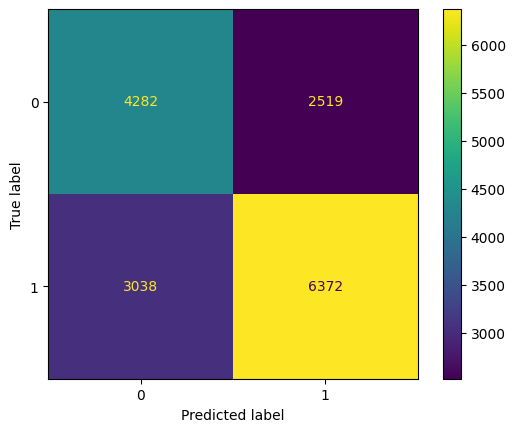

In [66]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_pred_lr, y_test)).plot()

На первый взгляд неплохие метрики качества у модели логистической регрессии, однако, матрица ошибок не радует. Попробуем сравнить с методом опорных векторов

In [67]:
sv = SVC(kernel="linear", probability=True)
sv.fit(X_train, y_train)
y_pred_sv = sv.predict(X_test)
print(f"Доля верных ответов: {accuracy_score(y_pred_sv, y_test)}")
print(f"Точность: {precision_score(y_pred_sv, y_test)}")
print(f"Полнота: {recall_score(y_pred_sv, y_test)}")
print(f"f1: {f1_score(y_pred_sv, y_test)}")

Доля верных ответов: 0.6874961445931774
Точность: 0.7810145090540996
Полнота: 0.6900526681904005
f1: 0.7327213253139179


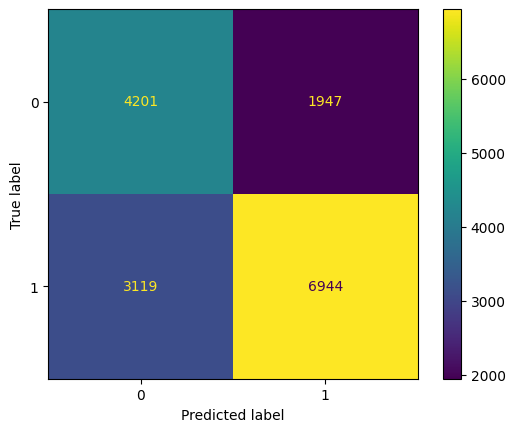

In [68]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_pred_sv, y_test)).plot()

Как и ожидалось, SVM дает лучший результат, однако, косячит с вероятностями принадлежности к классам

In [69]:
#посмотрим как делать прогноз на единичном объекте LogisticRegression
x = X_test[:1]
lr.predict_proba(x), y_test[:1]

(array([[0.12447346, 0.87552654]]),
 14085    1
 Name: target, dtype: int64)

In [71]:
#посмотрим как делать прогноз на единичном объекте SVC
x = X_test[:1]
sv.predict_proba(x), y_test[:1]

(array([[0.16074687, 0.83925313]]),
 14085    1
 Name: target, dtype: int64)

Попробуем подобрать параметры регуляризации для логистической регрессии

In [73]:
params = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
for C in params:
    lr = LogisticRegression(C=C)
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    print(accuracy_score(y_pred_lr, y_test))

0.6585034852877676
0.6577632471778422
0.6574548146320399
0.6572697551045587
0.6572080685953982
0.6572080685953982
0.6572080685953982


Грамотнее перебирать параметры с помощью специальной библиотеки GridSearch

In [79]:
parameters = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]}
lr = LogisticRegression()
grid_search = GridSearchCV(lr, parameters, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]},
             scoring='accuracy')

In [80]:
grid_search.best_score_, grid_search.best_params_

(0.661564173426636, {'C': 0.005})

Из заданного набора параметров оптимальней оказался С=0.005

Так как SVC медленно считает, то попробуем переразбить датасет на тренировочную и тестовую в пропорции 60:40

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((32421, 20), (32421,), (21614, 20), (21614,))

In [82]:
parameters = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
              'kernel': ['linear', 'rbf']}
svm = SVC()
grid_search = GridSearchCV(svm, parameters, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [83]:
grid_search.best_score_, grid_search.best_params_

(0.9052157552203819, {'C': 1, 'kernel': 'rbf'})

Вывод: датасет оказался нелинейно разделимым. выиграла модель SVC с ядром rbf и коэффициентом регуляризации C=1